# Productos de Amazon
Este data set consiste en 140 archivos csv con diferentes tipos de productos vendidos en Amazon durante el 2023. Realizaremos un análisis exploratorio donde buscaremos responder a las siguientes preguntas:
1. ¿Cuál es el precio promedio de teléfonos?
2. ¿Qué categorías contienen los productos con precios más altos?
3. ¿Existe una correlación entre precio y calificación en los productos?
4. ¿Cuál es el rango de precio dependiendo del tipo de subcategoría?

El dataset lo pueden encontrar en Kaggle en el siguiente Link para más información: https://www.kaggle.com/datasets/lokeshparab/amazon-products-dataset


## 1. Importar datos

In [182]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re 
import glob
import warnings

warnings.filterwarnings('ignore')

In [183]:
# Creamos una lista con el nombre de todos los archivos csv
# para importarlos en pandas
folder_path = './Datos'
file_list = glob.glob(folder_path + '/*.csv')
main_dataframe = pd.DataFrame(pd.read_csv(file_list[0]))
for i in range(1,len(file_list)):
    data = pd.read_csv(file_list[i])
    df = pd.DataFrame(data)
    main_dataframe = pd.concat([main_dataframe,df], axis = 0)
main_dataframe.reset_index(inplace=True, drop = True)

In [184]:
main_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103170 entries, 0 to 1103169
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   name            1103170 non-null  object 
 1   main_category   1103170 non-null  object 
 2   sub_category    1103170 non-null  object 
 3   image           1103170 non-null  object 
 4   link            1103170 non-null  object 
 5   ratings         751582 non-null   object 
 6   no_of_ratings   751582 non-null   object 
 7   discount_price  980844 non-null   object 
 8   actual_price    1067544 non-null  object 
 9   Unnamed: 0      551585 non-null   float64
dtypes: float64(1), object(9)
memory usage: 84.2+ MB


In [185]:
display(main_dataframe.head())

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,Unnamed: 0
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,"2,255","₹32,999","₹58,990",NaN
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,"2,948","₹46,490","₹75,990",NaN
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,"1,206","₹34,490","₹61,990",NaN
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69,"₹37,990","₹68,990",NaN
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630,"₹34,490","₹67,790",NaN


Observaciones:
- Existen columnas de tipo string (object) pero que contienen datos numéricos
- Los precios estan en rupias "₹" que es moneda de la india por lo que haremos la conversión a dolares.
- Hay columnas con datos nulos, pero que no vamos a descartar hasta las preguntas concretas.

## 2. Transformación y limpieza de datos

In [186]:
# Eliminamos columnas que no nos serviran para este analisis
df_cleaned = main_dataframe.copy()
df_cleaned.drop('Unnamed: 0', axis=1, inplace= True)
df_cleaned.drop('image', axis=1, inplace= True)
df_cleaned.drop('link', axis=1, inplace= True)

In [187]:
# Borramos duplicados
df_cleaned.drop_duplicates(inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533713 entries, 0 to 1058164
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            533713 non-null  object
 1   main_category   533713 non-null  object
 2   sub_category    533713 non-null  object
 3   ratings         378609 non-null  object
 4   no_of_ratings   378609 non-null  object
 5   discount_price  477909 non-null  object
 6   actual_price    519181 non-null  object
dtypes: object(7)
memory usage: 32.6+ MB


In [188]:
# Visualizamos algunos precios que pueden parecer mal escritos 
df_cleaned.loc[[388, 223377, 280942, 527570], ['discount_price','actual_price']]

,discount_price,actual_price
388,"₹99,750","₹1,28,900"
223377,₹589,"₹9,89,99,99,999"
280942,"₹99,750","₹1,28,900"
527570,"₹12,49,990","₹15,94,900"


Al indagar sobre la moneda rupia '₹' vemos que es por el estilo de escitura ya que manejan el lakh (1,00,000) equivalente a 100,000 y el crore (1,00,00,000) equivalente a 10,000,000. Por lo que solo será necesario eliminar el simbolo de rupias '₹'  y las comas ','.

In [189]:
# Eliminamos el simbolo de rupias '₹' 
df_cleaned[['discount_price','actual_price']] = df_cleaned[['discount_price','actual_price']].replace(to_replace=r'₹', value='', regex=True)

# Eliminamos las comas ',' 
df_cleaned[['discount_price','actual_price']] = df_cleaned[['discount_price','actual_price']].replace(to_replace=r',', value='', regex=True)

# Los pasamos a tipo numerico 
df_cleaned['discount_price'] = pd.to_numeric(df_cleaned['discount_price'], downcast='float', errors= 'coerce')
df_cleaned['actual_price'] = pd.to_numeric(df_cleaned['actual_price'], downcast='float', errors= 'coerce')


In [190]:
# Comprobamos que en efecto ya estan en formato correcto
df_cleaned.loc[[388, 223377, 280942, 527570], ['discount_price','actual_price']]

,discount_price,actual_price
388,99750.0,1.289000e+05
223377,589.0,9.900000e+09
280942,99750.0,1.289000e+05
527570,1249990.0,1.594900e+06


In [191]:
# Realizamos la conversion de rupias a dolares tomando en cuenta
# que una 1 rupia = 0.012 dolares
df_cleaned['discount_price'] = df_cleaned['discount_price'] * 0.012
df_cleaned['actual_price'] = df_cleaned['actual_price'] * 0.012

In [192]:
# Observamos que hay valores no numericos en los Raitings
df_cleaned['ratings'].unique()

array(['4.2', '4.0', '4.1', '4.3', '3.9', '3.8', '3.5', nan, '4.6', '3.3',
       '3.4', '3.7', '2.9', '5.0', '4.4', '3.6', '2.7', '4.5', '3.0',
       '3.1', '3.2', '4.8', '4.7', '2.5', '1.0', '2.6', '2.8', '2.3',
       '1.7', 'Get', '1.8', '2.4', '4.9', '2.2', '1.6', '1.9', '2.0',
       '1.4', '2.1', 'FREE', '1.2', '1.3', '1.5', '₹68.99', '₹65', '1.1',
       '₹70', '₹100', '₹99', '₹2.99', 4.0, 3.7, 3.4, 4.1, 3.8, 3.6, 4.2,
       3.9, 3.2, 3.5, 5.0, 3.3, 2.6, 4.5, 4.3, 4.7, 3.0, 3.1, 4.4, 4.6,
       1.0, 4.9, 2.9, 2.7, 2.2, 2.5, 4.8, 2.0, 1.7, 1.9, 2.8, 2.4, 1.6,
       2.3, 1.8, 1.4, 1.3, 2.1, 1.5], dtype=object)

In [193]:
# Nos quedamos con los valores numericos y el resto lo cambiamos a NaN, 
# como no hay ',' en los numeros, podemos usar directamente pd.to_numeric()
df_cleaned['ratings'] = pd.to_numeric(df_cleaned['ratings'], downcast='float', errors= 'coerce')
df_cleaned['ratings'].unique()

array([4.2, 4. , 4.1, 4.3, 3.9, 3.8, 3.5, nan, 4.6, 3.3, 3.4, 3.7, 2.9,
       5. , 4.4, 3.6, 2.7, 4.5, 3. , 3.1, 3.2, 4.8, 4.7, 2.5, 1. , 2.6,
       2.8, 2.3, 1.7, 1.8, 2.4, 4.9, 2.2, 1.6, 1.9, 2. , 1.4, 2.1, 1.2,
       1.3, 1.5, 1.1], dtype=float32)

In [194]:
# Vemos que hay strings en la columna numerica no_of_ratings
df_cleaned['no_of_ratings'].loc[[1,2,3,437, 473, 474, 557502, 580084]]

1                         2,948
2                         1,206
3                            69
437       Only 2 left in stock.
473       Only 1 left in stock.
474       Only 1 left in stock.
557502    Only 1 left in stock.
580084    Only 1 left in stock.
Name: no_of_ratings, dtype: object

In [195]:
# Eliminamos comas
df_cleaned['no_of_ratings'] = df_cleaned['no_of_ratings'].replace(to_replace=r',', value='', regex=True)

# Pasamos a datos numericos, las cadenas de texto las pasamos a valores nulos NaN
df_cleaned['no_of_ratings'] = pd.to_numeric(df_cleaned['no_of_ratings'], downcast='float', errors= 'coerce')

In [196]:
# Corroboramos que se eliminaron las cadenas de texto y que solo nos quedamos
# con valores numericos
df_cleaned['no_of_ratings'].loc[[1,2,3,437, 473, 474, 557502, 580084]]

1         2948.0
2         1206.0
3           69.0
437          NaN
473          NaN
474          NaN
557502       NaN
580084       NaN
Name: no_of_ratings, dtype: float32

In [197]:
# Creamos una columna con el porcentaje total que se le descontó a cada producto
df_cleaned['discount_porcent (%)'] = (df_cleaned['actual_price']-df_cleaned['discount_price']) * 100 / df_cleaned['actual_price']

In [198]:
# Vemos que al inicio de los ombres viene el nombre de la empresa que fabrico
# el producto, por lo que creamos una columna con esta informacion, eliminand
# algunas palabras que no corresponde a empresas
df_cleaned['Company'] = df_cleaned['name'].str.split().str[0]
df_cleaned['Company']  = df_cleaned['Company'].apply(lambda x: np.NaN if x in ['PC', 'U.S.', 'The', 'Red'] else x)

In [199]:
# Vemos un resumen del dataframe despues de la limpieza
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533713 entries, 0 to 1058164
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   name                  533713 non-null  object 
 1   main_category         533713 non-null  object 
 2   sub_category          533713 non-null  object 
 3   ratings               372445 non-null  float32
 4   no_of_ratings         372445 non-null  float32
 5   discount_price        477909 non-null  float64
 6   actual_price          519181 non-null  float64
 7   discount_porcent (%)  477909 non-null  float64
 8   Company               519435 non-null  object 
dtypes: float32(2), float64(3), object(4)
memory usage: 52.8+ MB


Observaciones:
- Eliminamos duplicados, reduciendo a la mitad la tabla de datos.
- Eliminamos las cadenas de texto de la columnas con variables numericas.
- Se hizo la conversión a dolares para un mejor entendimiento del rango de precio de los productos.
- Se hizo una nueva columna 'discount_porcent (%)' para identificar que productos recibieron un mayor descuento.
- Se hizo una nueva columna 'company' con el nombre de la empresa de donde viene el producto.

## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Análisis univariado

In [200]:
# Exploramos las principales estadísticas de las variales numericas.
df_cleaned.describe()

,ratings,no_of_ratings,discount_price,actual_price,discount_porcent (%)
count,372445.000000,372445.000000,477909.000000,5.191810e+05,477909.000000
mean,3.825906,806.673584,30.293233,2.821953e+02,49.852605
std,0.754476,8466.897461,112.102140,1.648790e+05,21.426830
min,1.000000,1.000000,0.096000,0.000000e+00,0.000529
25%,3.500000,4.000000,4.668000,1.188000e+01,35.583766
50%,3.900000,20.000000,7.920000,1.918800e+01,51.113586
75%,4.200000,131.000000,16.320000,3.598800e+01,66.711141
max,5.000000,589547.000000,14999.880000,1.188000e+08,99.999994


Oservaciones:
- Vemos que el rating va de 1 a 5 que en efecto correspode con las calificaciones que podemos dar en Amazon, donde podemos decir que puede que siga una distribucion normal debido a que la mediana (3.9) y la media (3.82) son muy cercanas. Además, la mayoría de los productos tienen buenas calificaciones pues el 75% de ellos tienen una calificación mayor al 3.5.
- De la columna de No. de raitings podemos decir que el 25% reciben más de 131 calificaciones, por lo que generalmente muy poca gente comenta.
- De los precios de descuento vemos que la mayoría de los productos no pasan de los $16.32 dolares, siedo el producto con el precio más alto de $14,999.88.
- De los precios actuales vemos que la mayoría de los productos no pasan de los $35.99 dolares, donde el producto con el precio más alto es de $118,800,000 el cual es muy superior en comparación al precio de descuento maximo, esto puede dar la sospecha de valores extremos. Más adelate verificaremos si estos precios pueden ser reales o no.
- Sobre los descuentos vemos que más de la mitad sufren de descuentos mayores al 50% en algún momento de su periodo en venta.

In [201]:
# Vamos a calcular cuantas categorias, subcategorias y compañias tenemos
main_categories_proportions = df_cleaned['main_category'].value_counts()
subcategories_proportions = df_cleaned['sub_category'].value_counts()
company_proportions = df_cleaned['Company'].value_counts()

main_categories_proportions.sort_values(ascending=False, inplace=True)
subcategories_proportions.sort_values(ascending=False, inplace=True)

print('Número de Categorías principales: ', len(main_categories_proportions))
print('Número de Subcategorías: ', len(subcategories_proportions))
print('Número de Compañias: ', len(company_proportions))

Número de Categorías principales:  20
Número de Subcategorías:  112
Número de Compañias:  50051


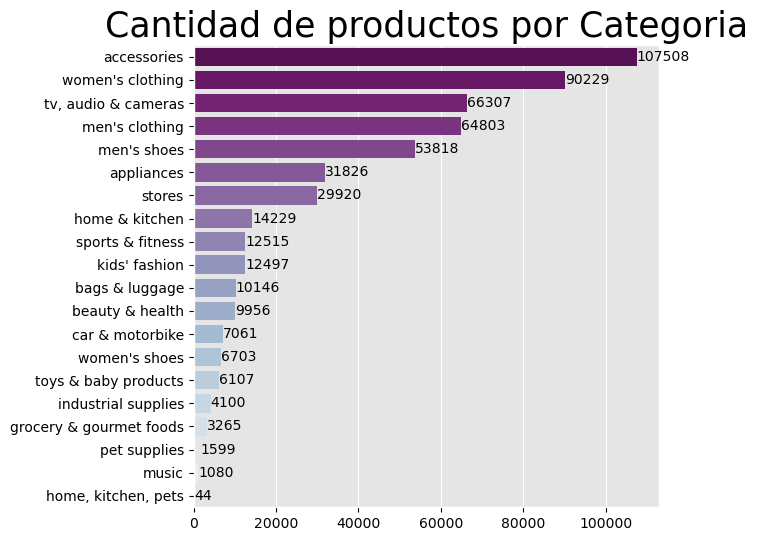

In [202]:
plt.style.use('ggplot')

# Graficamos la cantidad de productos por categoria
plt.figure(figsize=(6,6))
ax = sns.barplot(x = main_categories_proportions.values,
            y = main_categories_proportions.index,
           palette = 'BuPu_r'
        )
ax.bar_label(ax.containers[0])
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_title('Cantidad de productos por Categoria', fontsize = 25)
plt.show()

In [203]:
accesories_percentage = main_categories_proportions['accessories'] / len(df_cleaned) * 100
women_clothe_percentage = main_categories_proportions["women's clothing"] / len(df_cleaned) * 100
tv_audio_percentage = main_categories_proportions['tv, audio & cameras'] / len(df_cleaned) * 100
print(f'Porcentaje de productos que pertenecen a Accesorios: {accesories_percentage:.2f}%')
print(f'Porcentaje de productos que pertenecen a Ropa de mujer: {women_clothe_percentage:.2f}%')
print(f'Porcentaje de productos que pertenecen a TV, audio y cámaras: {tv_audio_percentage:.2f}%')

Porcentaje de productos que pertenecen a Accesorios: 20.14%
Porcentaje de productos que pertenecen a Ropa de mujer: 16.91%
Porcentaje de productos que pertenecen a TV, audio y cámaras: 12.42%


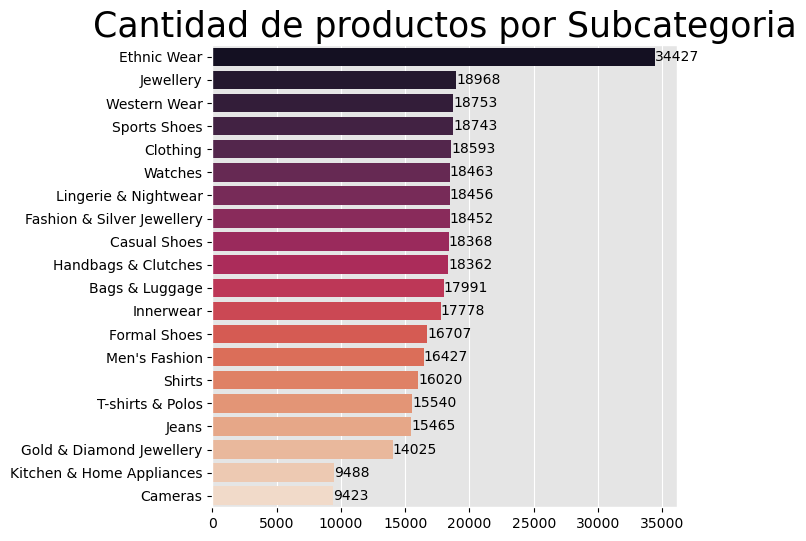

In [204]:
# Graficamos la cantidad de productos por subcategoria, tomando
# las primeras 20 con mayor cantidad de productos
plt.figure(figsize=(6,6))
ax = sns.barplot(x = subcategories_proportions[:20].values,
            y = subcategories_proportions[:20].index,
           palette = 'rocket'
        )
ax.bar_label(ax.containers[0])
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_title('Cantidad de productos por Subcategoria', fontsize = 25)
plt.show()

In [205]:
ethnic_percentage = subcategories_proportions['Ethnic Wear'] / len(df_cleaned) * 100
jewellery_percentage = subcategories_proportions["Jewellery"] / len(df_cleaned) * 100
western_percentage = subcategories_proportions['Western Wear'] / len(df_cleaned) * 100
print(f'Porcentaje de productos que pertenecen a Ropa étnica: {ethnic_percentage:.2f}%')
print(f'Porcentaje de productos que pertenecen a Joyas: {jewellery_percentage:.2f}%')
print(f'Porcentaje de productos que pertenecen a Ropa Vaquero: {western_percentage:.2f}%')

Porcentaje de productos que pertenecen a Ropa étnica: 6.45%
Porcentaje de productos que pertenecen a Joyas: 3.55%
Porcentaje de productos que pertenecen a Ropa Vaquero: 3.51%


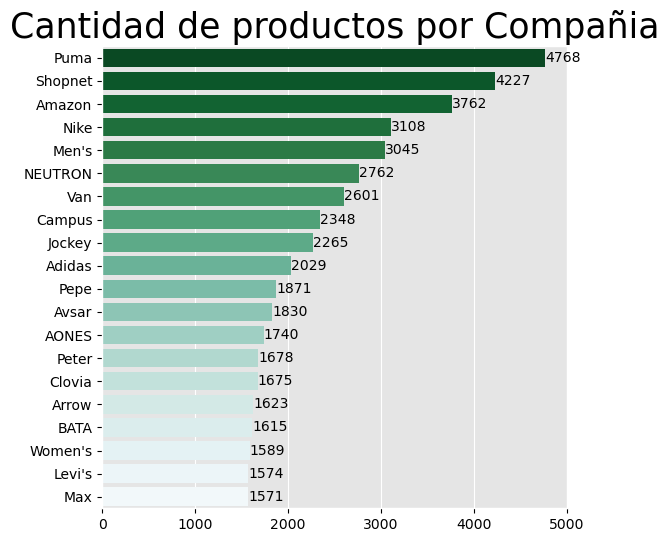

In [206]:
# Graficamos la cantidad de productos por compañia, tomamos las primeras 20
plt.figure(figsize=(6,6))
ax = sns.barplot(x = company_proportions.values[:20],
            y = company_proportions.index[:20],
           palette = 'BuGn_r'
        )
ax.bar_label(ax.containers[0])
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_title('Cantidad de productos por Compañia', fontsize = 25)
plt.show() 

In [207]:
puma_percentage = company_proportions['Puma'] / len(df_cleaned) * 100
shopnet_percentage = company_proportions["Shopnet"] / len(df_cleaned) * 100
amazon_percentage = company_proportions['Amazon'] / len(df_cleaned) * 100
print(f'Porcentaje de productos que pertenecen a Puma: {puma_percentage:.2f}%')
print(f'Porcentaje de productos que pertenecen a Shopnet: {shopnet_percentage:.2f}%')
print(f'Porcentaje de productos que pertenecen a Amazon: {amazon_percentage:.2f}%')

Porcentaje de productos que pertenecen a Puma: 0.89%
Porcentaje de productos que pertenecen a Shopnet: 0.79%
Porcentaje de productos que pertenecen a Amazon: 0.70%


Observaciones:
- Vemos que tenemos 20 categorías principales, de las cuales, la que tenemos con mayor cantidad de productos registrados es Accesorios (20%), seguido de la Ropa para Mujeres (17%) y los artículos electrónicos como Cámaras y Televisiones (12%).
- Tenemos 112 subcategorías, donde la Ropa Etnica es la que tiene mayor número de registro (6%), seguido de las Joyas (4%) y la ropa tipo vaquero 'Western Wear' (4%).
- Las compañias con mayor cantidad de productos son Puma (0.89%), Shopnet (0.79%) y orignales de Amazon (0.70%).

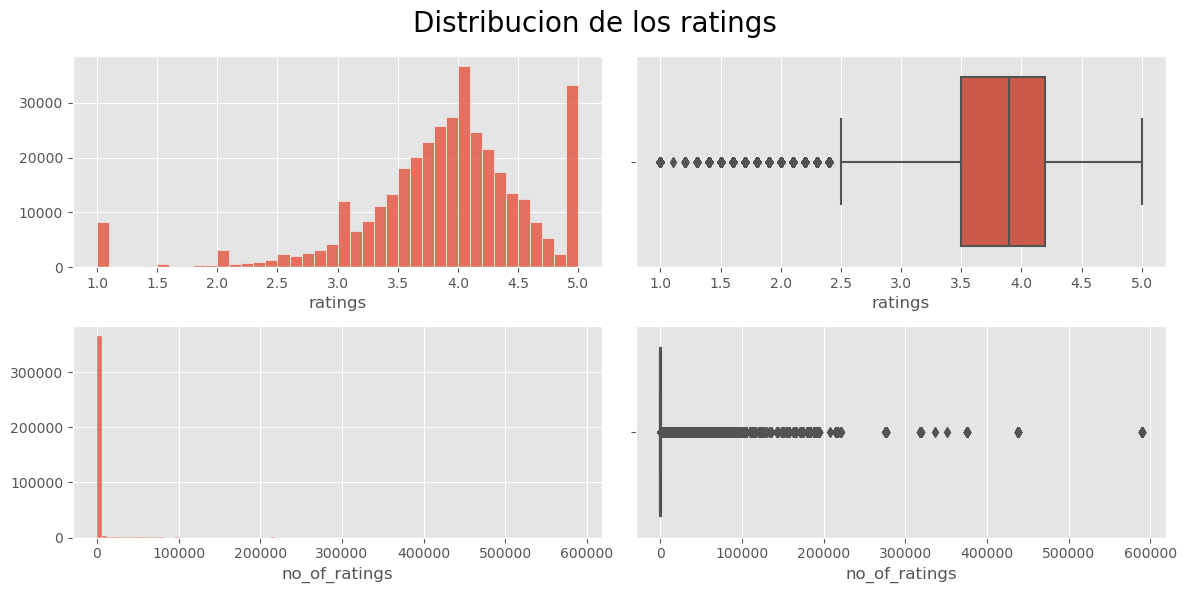

In [208]:
# Distribución de los Ratings
f, axes = plt.subplots(2,2, figsize=(12,6))
sns.histplot(data = df_cleaned, x = 'ratings', bins = 40, ax = axes[0,0])
sns.boxplot(data = df_cleaned, x = 'ratings',ax = axes[0,1])
sns.histplot(data = df_cleaned, x = 'no_of_ratings', bins = 100, ax = axes[1,0])
sns.boxplot(data = df_cleaned, x = 'no_of_ratings', ax = axes[1,1] )
axes[0,0].set_ylabel(None)
axes[0,1].set_ylabel(None)
axes[1,0].set_ylabel(None)
axes[1,1].set_ylabel(None)
f.suptitle('Distribucion de los ratings', fontsize = 20) 
f.tight_layout()
plt.show()

Observaciones:
- Los ratings siguen una distribucion normal sesgada a la derecha, lo que indica que la mayoría de las calificaciones son positivas (mayor a 3.5), por lo que los productos vendidos en 2023 han sido bien recibidos por la gente. Las calificaciones más comunes son entre 4.0-4.1 y 4.9-5 de acuerdo al histograma de ratings. 
- Además, vemos que el número de calificaciones a los productos tiende a ser bajo y casi todos los productos contienen 6000 calificaciones o menos. Esto se ve en la línea vertical del histograma de no_of_ratings.

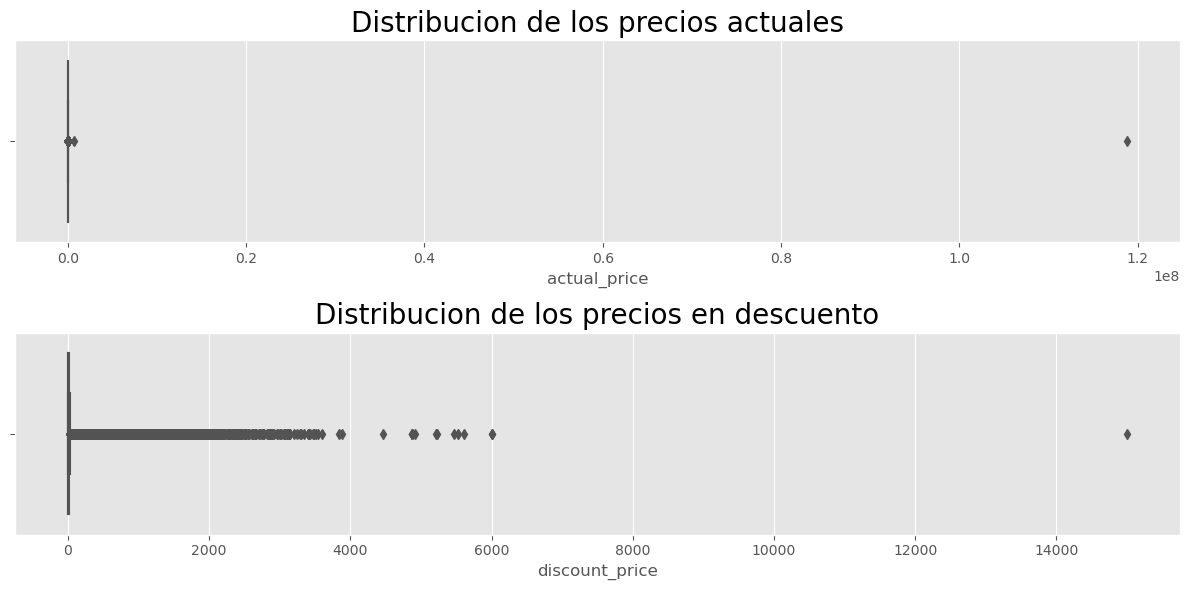

In [209]:
# Distribución de los precios
f, axes = plt.subplots(2,1, figsize=(12,6))
sns.boxplot(data = df_cleaned, x = 'actual_price', ax = axes[0])
sns.boxplot(data = df_cleaned, x = 'discount_price', ax = axes[1])
axes[0].set_ylabel(None)
axes[1].set_ylabel(None)
axes[0].set_title('Distribucion de los precios actuales', fontsize = 20) 
axes[1].set_title('Distribucion de los precios en descuento', fontsize = 20)
f.tight_layout()
plt.show()

In [210]:
# Vemos la presencia de valores extremos por lo que vamos a averiguar de que 
# productos se trata
df_cleaned.sort_values(by = ['actual_price'], ascending=False).head(10)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,discount_porcent (%),Company
223377,"Marutivilla Insect Killer, Mosquito Killer Lig...",home & kitchen,Garden & Outdoors,2.0,1.0,7.068,1.188000e+08,99.999994,Marutivilla
431502,Clovia Women's Activewear Ankle Length Printed...,sports & fitness,Running,3.2,4.0,8.256,7.329959e+05,99.998874,Clovia
527570,Samsung 214 cm (85 inches) 8K Ultra HD Smart N...,"tv, audio & cameras",Televisions,4.0,10.0,14999.880,1.913880e+04,21.625807,Samsung
340701,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat...,accessories,Jewellery,NaN,NaN,4872.108,1.440000e+04,66.165917,USPTO
419071,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat...,stores,Men's Fashion,NaN,NaN,4872.108,1.440000e+04,66.165917,USPTO
363015,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat...,kids' fashion,Kids' Fashion,NaN,NaN,4872.108,1.440000e+04,66.165917,USPTO
178250,Venus Gems Gallery Real Diamond Ring 2 Carat O...,accessories,Fashion & Silver Jewellery,NaN,NaN,5999.988,1.200000e+04,50.000100,Venus
339374,Venus Gems Gallery Real Diamond Ring 2 Carat O...,accessories,Jewellery,NaN,NaN,5999.988,1.200000e+04,50.000100,Venus
339512,USPTO 2.85 Carat Real GIA Certifed Diamond Loo...,accessories,Jewellery,NaN,NaN,5519.988,1.104000e+04,50.000109,USPTO
357955,Alaska Gems Gallery Colombian Panna 8 Ratti 7....,accessories,Jewellery,NaN,NaN,5231.988,1.046400e+04,50.000115,Alaska


Al indagar sobre los primeros productos, vemos que el primero es solo una lampara de mosquitos que ronda en los $5 dolares, por lo su precio esta mal . Lo mismo sucede con el segundo producto que es una malla deportiva para mujer y ronda en los $25 dolares. Vamos a convertir estos precios a NaN, del resto de productos los precios van acorde a lo que son (pantallas y joyeria).

In [211]:
# Eliminamos el precio de los primeros 2 productos
df_cleaned.loc[[223377,431502],'actual_price'] = [np.NaN, np.NaN]

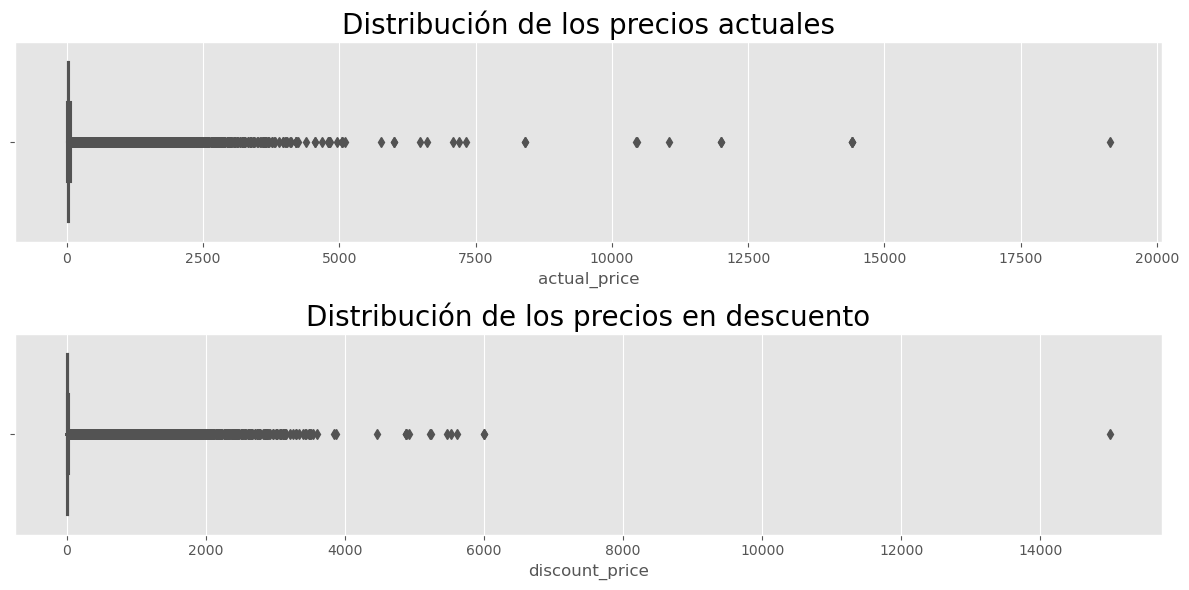

In [212]:
# Graficamos nuevamente la distribución de los precios
f, axes = plt.subplots(2,1, figsize=(12,6))
sns.boxplot(data = df_cleaned, x = 'actual_price', ax = axes[0])
sns.boxplot(data = df_cleaned, x = 'discount_price', ax = axes[1])
axes[0].set_ylabel(None)
axes[1].set_ylabel(None)
axes[0].set_title('Distribución de los precios actuales', fontsize = 20) 
axes[1].set_title('Distribución de los precios en descuento', fontsize = 20)
f.tight_layout()
plt.show()

In [213]:
# Obtenemos percentiles de interes de los precios
mediana = df_cleaned['actual_price'].quantile(.50)
percentil_90 = df_cleaned['actual_price'].quantile(.90)
print("Mediana (50%):", mediana)
print("Percentil 90 (90%):", percentil_90)

Mediana (50%): 19.188
Percentil 90 (90%): 88.788


In [214]:
# Obtenemos percentiles de interes de los precios en descuento
mediana = df_cleaned['discount_price'].quantile(.50)
percentil_90 = df_cleaned['discount_price'].quantile(.90)
print("Mediana (50%):", mediana)
print("Percentil 90 (90%):", percentil_90)

Mediana (50%): 7.92
Percentil 90 (90%): 41.988


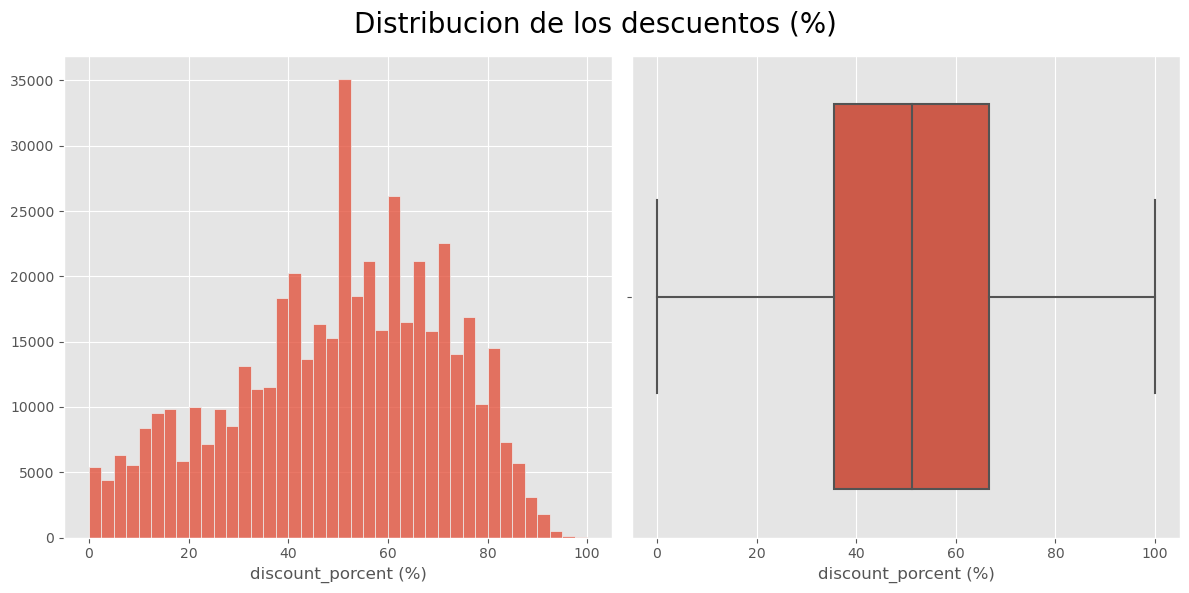

In [215]:
# Distribución de los descuentos
f, axes = plt.subplots(1,2, figsize=(12,6))
sns.histplot(data = df_cleaned, x = 'discount_porcent (%)', bins = 40, ax = axes[0])
sns.boxplot(data = df_cleaned, x = 'discount_porcent (%)',ax = axes[1])
axes[0].set_ylabel(None)
axes[1].set_ylabel(None)
f.suptitle('Distribucion de los descuentos (%)', fontsize = 20) 
f.tight_layout()
plt.show()

In [216]:
# Obtenemos percentiles de interes de los % de descuento
mediana = df_cleaned['discount_porcent (%)'].quantile(.50)
percentil_90 = df_cleaned['discount_porcent (%)'].quantile(.90)
percentil_99 = df_cleaned['discount_porcent (%)'].quantile(.99)
print("Mediana (50%):", mediana)
print("Percentil 90 (90%):", percentil_90)
print("Percentil 99 (99%):", percentil_99)

Mediana (50%): 51.113585746102444
Percentil 90 (90%): 76.69223074358119
Percentil 99 (99%): 87.86969567081012


Observaciones:
- Podemos observar que la mayoría de los precios se encuentran concentrados alrededor de los $19 dolares para los precios actuales y $7.92 para los precios en descuento. El 90% de los productos no supera los $90 dolares en su precio actual ni los $42 dolares en su precio de descuento Donde el producto más caro es una pantalla Samsung de 85 pulgadas con un costo de $19138.
- Vemos a partir de la distribución de los descuentos que son variados pero la mayoría se concentran en porcentajes de entre el 40% y 60% por lo que los productos en general reciben buenos descuentos. El 1% de los productos llegan a recibir más del 87% de descuento


#

### 3.2 Analisis Multivariado

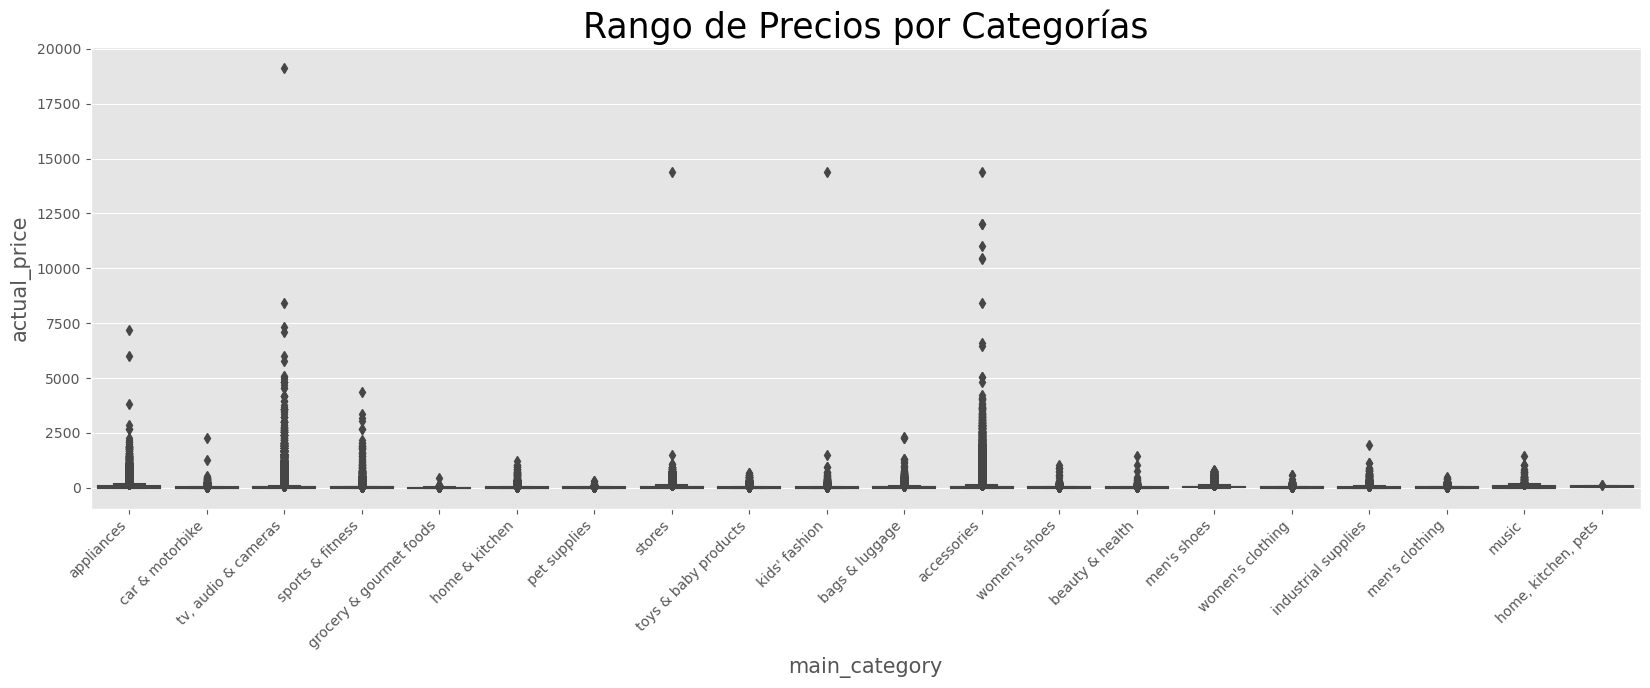

In [217]:
# Rangos de precios por categorias
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=df_cleaned, x="main_category", y="actual_price")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('actual_price', fontsize = 15)
ax.set_xlabel('main_category', fontsize = 15)
ax.set_title('Rango de Precios por Categorías', fontsize = 25) 
plt.show()

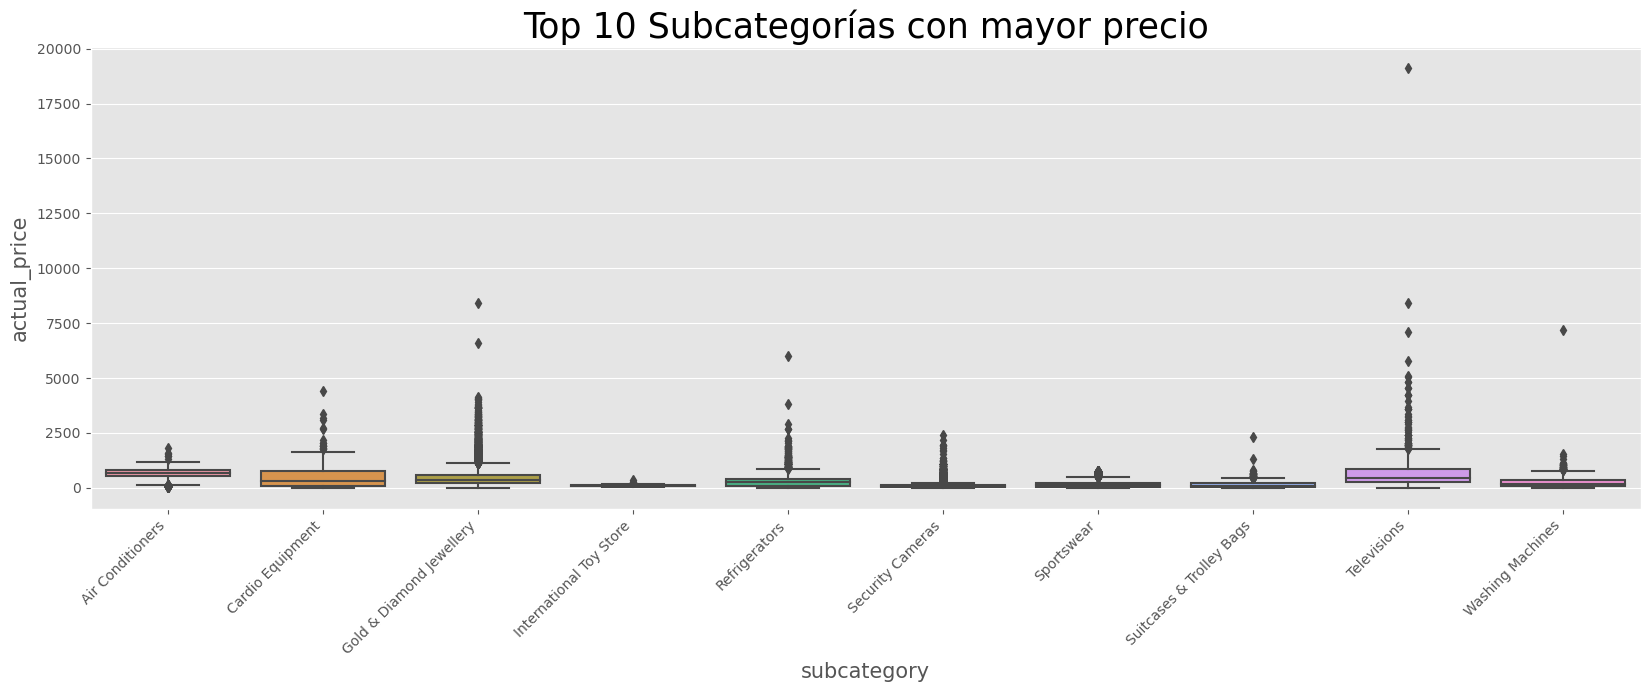

In [218]:
# Buscamos las 10 subcategorias con mayor precio tomando como criterio el
# de mayor mediana en los datos
subcategories_order_by_price = df_cleaned.groupby('sub_category')['actual_price'].describe().sort_values(by = '50%', ascending = False)
top_10_subcategories_by_price = subcategories_order_by_price.index[:10]
df_cleaned_subcategory_prices= df_cleaned.loc[df_cleaned['sub_category'].isin(top_10_subcategories_by_price)]

# Graficamos el rango de precios de las 10 subcategorías con mayor descuento
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=df_cleaned_subcategory_prices, x="sub_category", y="actual_price")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('actual_price', fontsize = 15)
ax.set_xlabel('subcategory', fontsize = 15)
ax.set_title('Top 10 Subcategorías con mayor precio', fontsize = 25) 
plt.show()


Observaciones:
- Identificamos que la Categoría más cara es la correspondiente a 'tv, audio & cameras', debido a que cuenta con el producto más caro de la lista que corresponde a la televisión Samsung de 85 pulgadas. Seguido de las categorías 'stores', "kid's fashion" y 'accesories'.
- En cuanto a Subcategorías, apreciamos que las que tienden a ser más caras son las joyerías como 'Gold & Diamond Jewellery' y los electrodomesticos como 'Televisions', 'Washing Machines', 'Refrigerators', 'Air Conditioners'.
- Con esto podemos decir que los electrodomésticos y las joyerías y son los productos más caros.

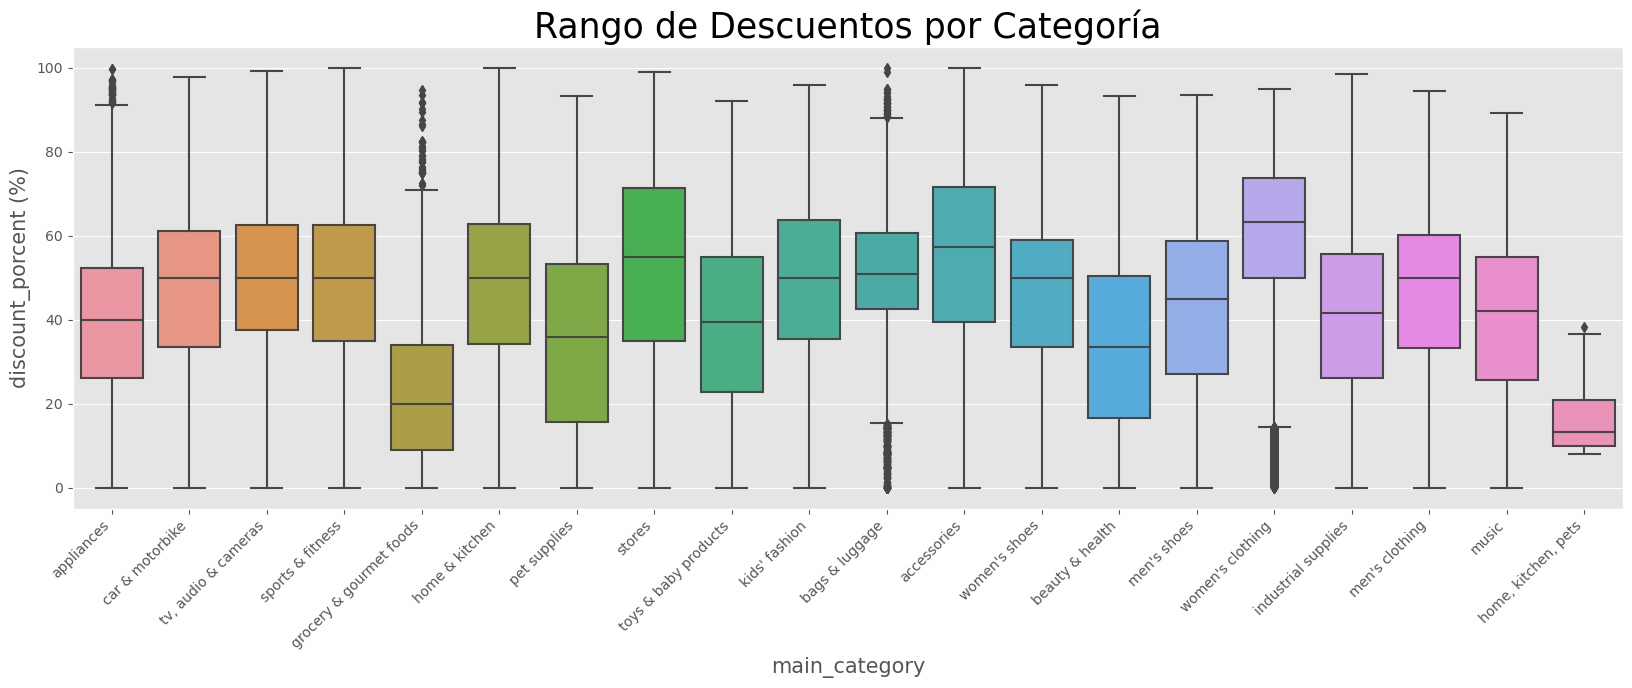

In [219]:
# Descuentos por categoría.
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=df_cleaned, x="main_category", y="discount_porcent (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('discount_porcent (%)', fontsize = 15)
ax.set_xlabel('main_category', fontsize = 15)
ax.set_title('Rango de Descuentos por Categoría', fontsize = 25) 
plt.show()

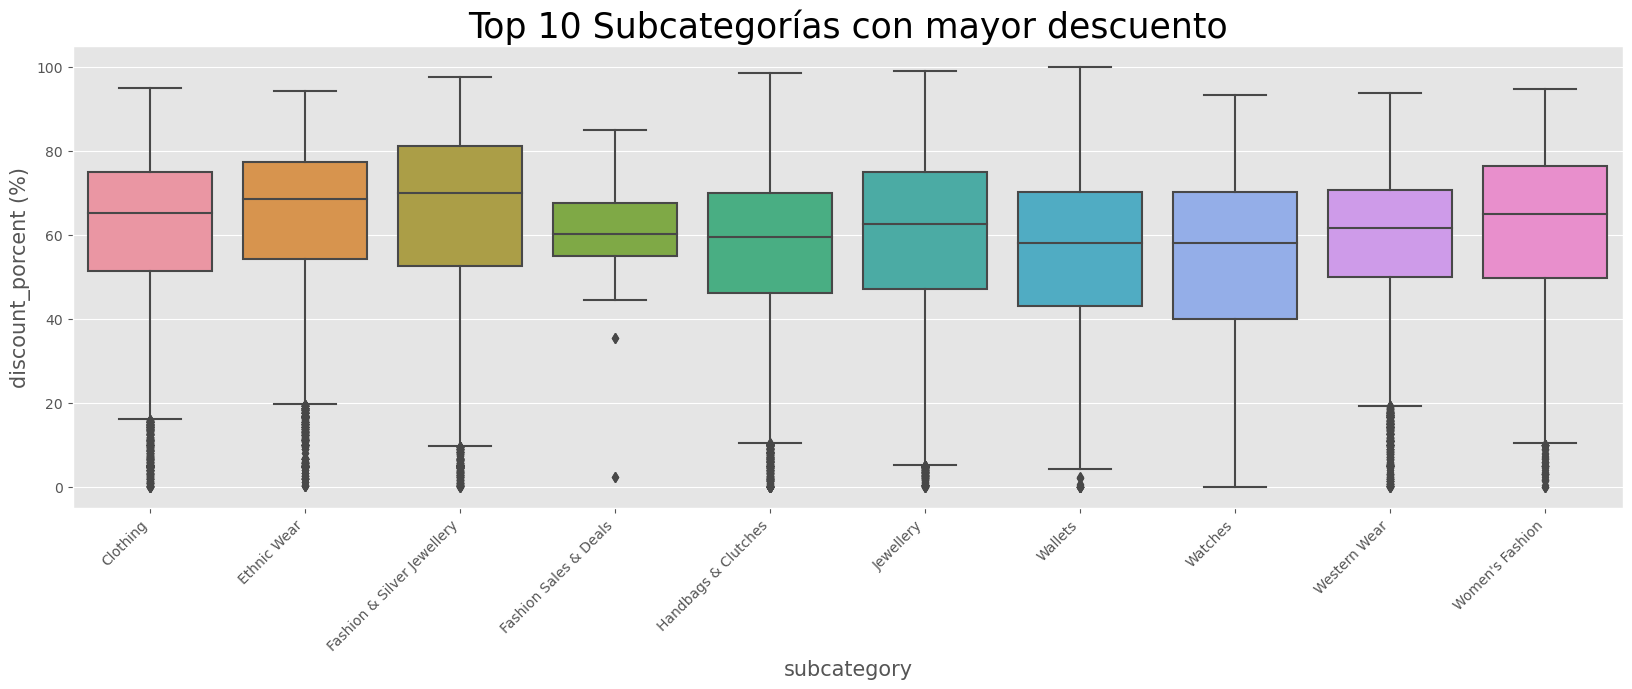

In [220]:
# Buscamos las 10 subcategorias con mayor descuento tomando como criterio el
# de mayor mediana en sus datos
subcategories_order_by_discount = df_cleaned.groupby('sub_category')['discount_porcent (%)'].describe().sort_values(by = '50%', ascending = False)
top_10_subcategories_by_discount = subcategories_order_by_discount.index[:10]
df_cleaned_subcategory_discount= df_cleaned.loc[df_cleaned['sub_category'].isin(top_10_subcategories_by_discount)]

# Graficamos el rango de precios de las 10 subcategorías con mayor descuento
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=df_cleaned_subcategory_discount, x="sub_category", y="discount_porcent (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('discount_porcent (%)', fontsize = 15)
ax.set_xlabel('subcategory', fontsize = 15)
ax.set_title('Top 10 Subcategorías con mayor descuento', fontsize = 25) 
plt.show()

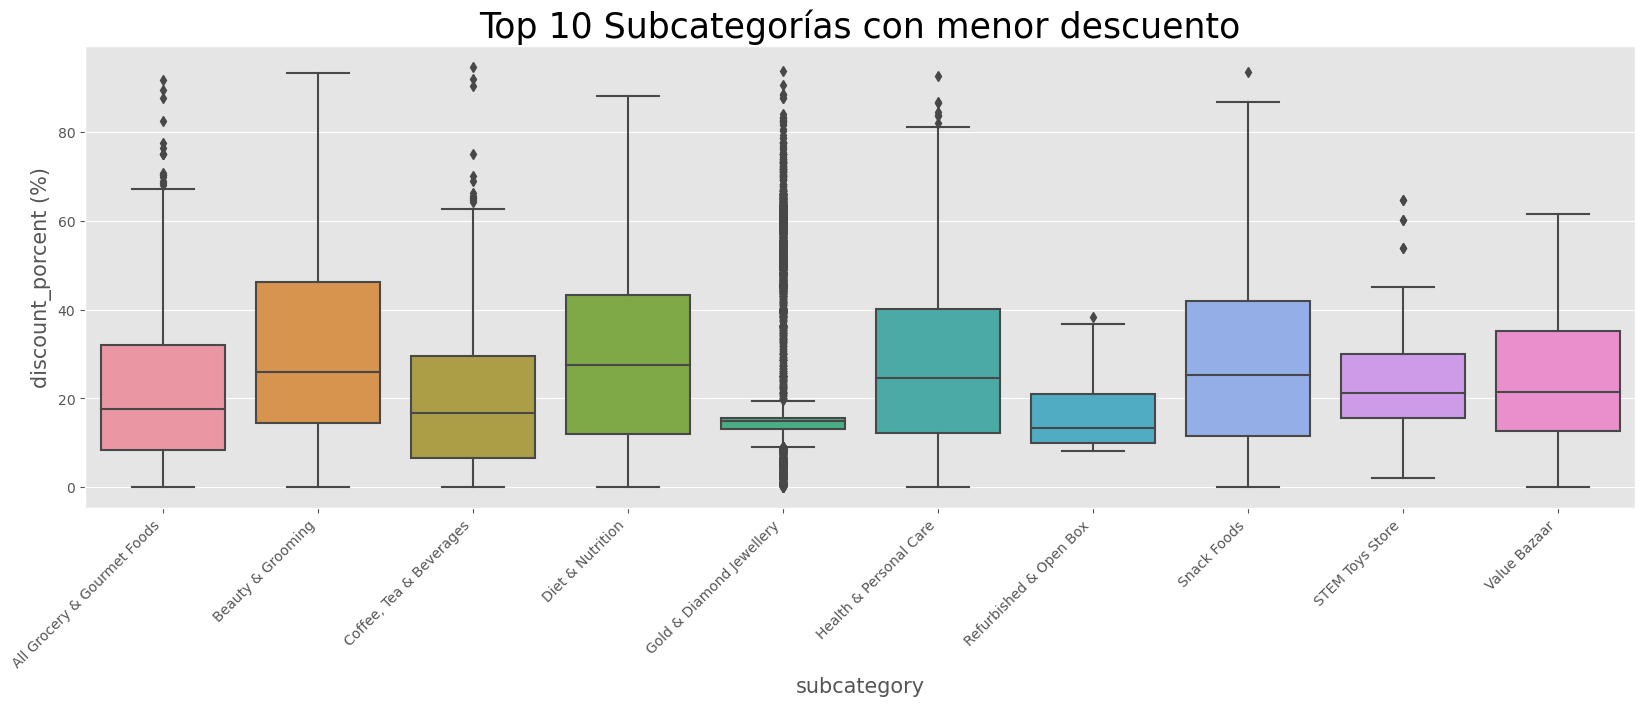

In [221]:
# Buscamos las 10 subcategorias con menor descuento tomando como criterio el
# de mayor mediana en sus datos
subcategories_order_by_discount = df_cleaned.groupby('sub_category')['discount_porcent (%)'].describe().sort_values(by = '50%', ascending = True)
top_10_subcategories_by_discount = subcategories_order_by_discount.index[:10]
df_cleaned_subcategory_discount= df_cleaned.loc[df_cleaned['sub_category'].isin(top_10_subcategories_by_discount)]

# Graficamos el rango de precios de las 10 subcategorías con menor descuento
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=df_cleaned_subcategory_discount, x="sub_category", y="discount_porcent (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('discount_porcent (%)', fontsize = 15)
ax.set_xlabel('subcategory', fontsize = 15)
ax.set_title('Top 10 Subcategorías con menor descuento', fontsize = 25) 
plt.show()

Observaciones
- Vemos que las categorías con los mayores descuentos en sus productos son las de 'women's clothing', seguido de 'stores' y 'accesories'.
- Las subcategorías con los mayores descuentos son las dejoyería como 'Fashion & Silver Jewellery' y 'Jewellery', además de las que corresponden a ropa como 'Women's Fashion', 'Clothing' y 'Ethnic Wear'. Mientras que las que ofrecen menor descuento son las que corresponden a comida como 'Coffee, Tea & Beverages', 'All Grocery & Gourmet Foods', 'Snack Foods' y 'Diet & Nutrition', además de algunos correspodientes salud y belleza como 'Health & Personal Care' y 'Beauty & Grooming'

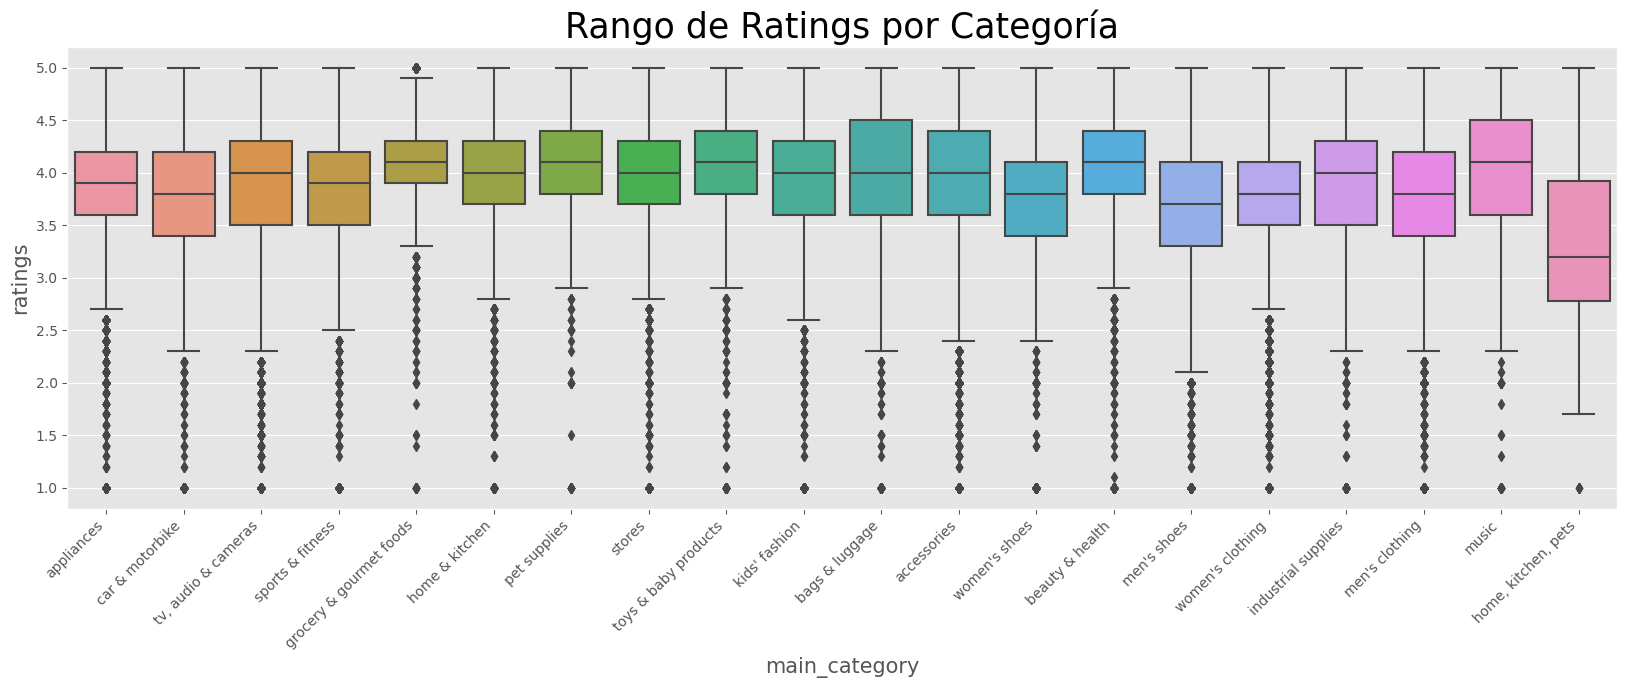

In [222]:
# Ratings por categoría.
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=df_cleaned, x="main_category", y="ratings")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('ratings', fontsize = 15)
ax.set_xlabel('main_category', fontsize = 15)
ax.set_title('Rango de Ratings por Categoría', fontsize = 25) 
plt.show()

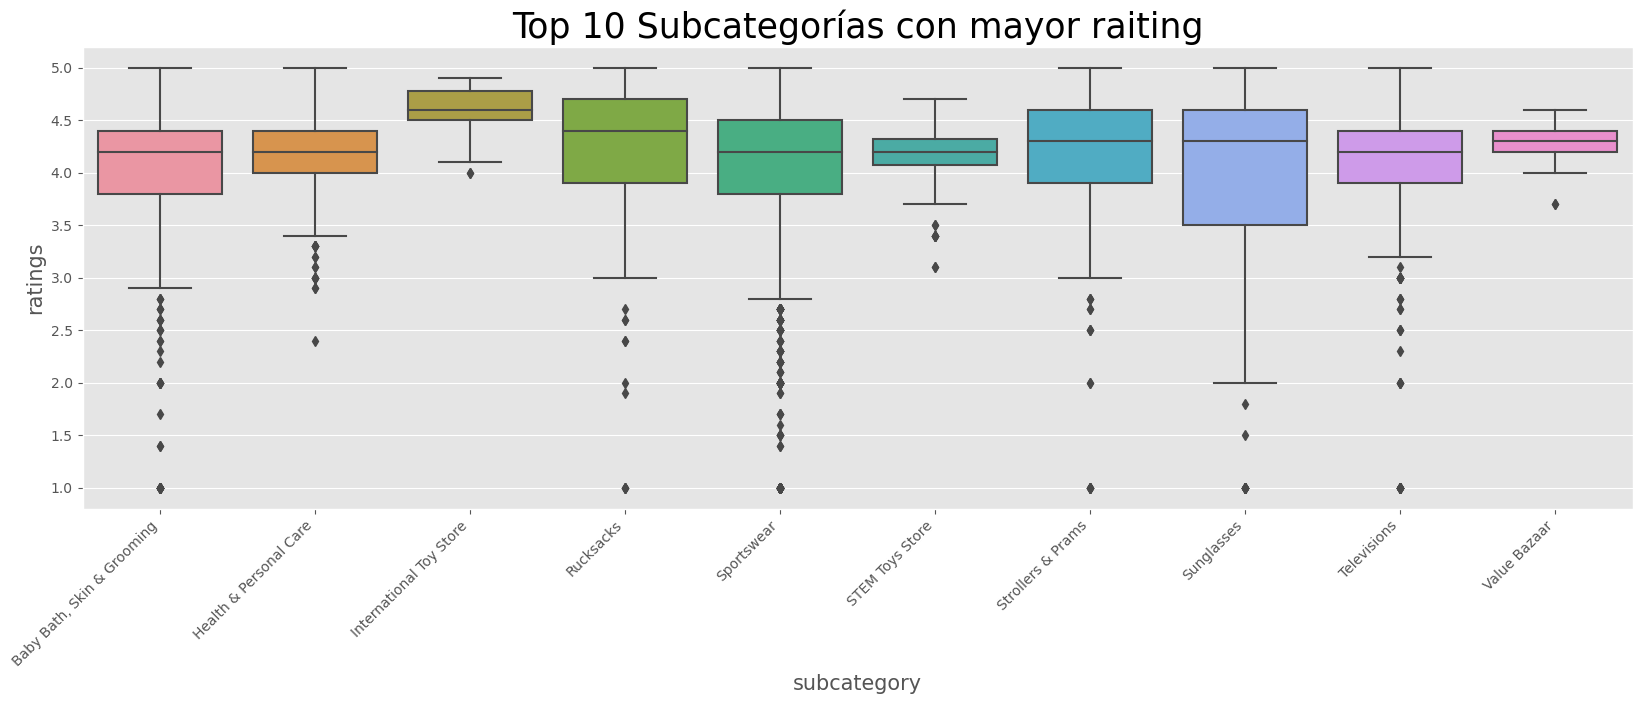

In [223]:
# Buscamos las 10 subcategorias con mayor rating tomando como criterio el
# de mayor mediana en los datos
subcategories_order_by_ratings = df_cleaned.groupby('sub_category')['ratings'].describe().sort_values(by = '50%', ascending = False)
top_10_subcategories_by_ratings = subcategories_order_by_ratings.index[:10]
df_cleaned_subcategory_ratings= df_cleaned.loc[df_cleaned['sub_category'].isin(top_10_subcategories_by_ratings)]

# Graficamos el rango de precios de las 10 subcategorías con mayor raiting
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=df_cleaned_subcategory_ratings, x="sub_category", y="ratings")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('ratings', fontsize = 15)
ax.set_xlabel('subcategory', fontsize = 15)
ax.set_title('Top 10 Subcategorías con mayor raiting', fontsize = 25) 
plt.show()

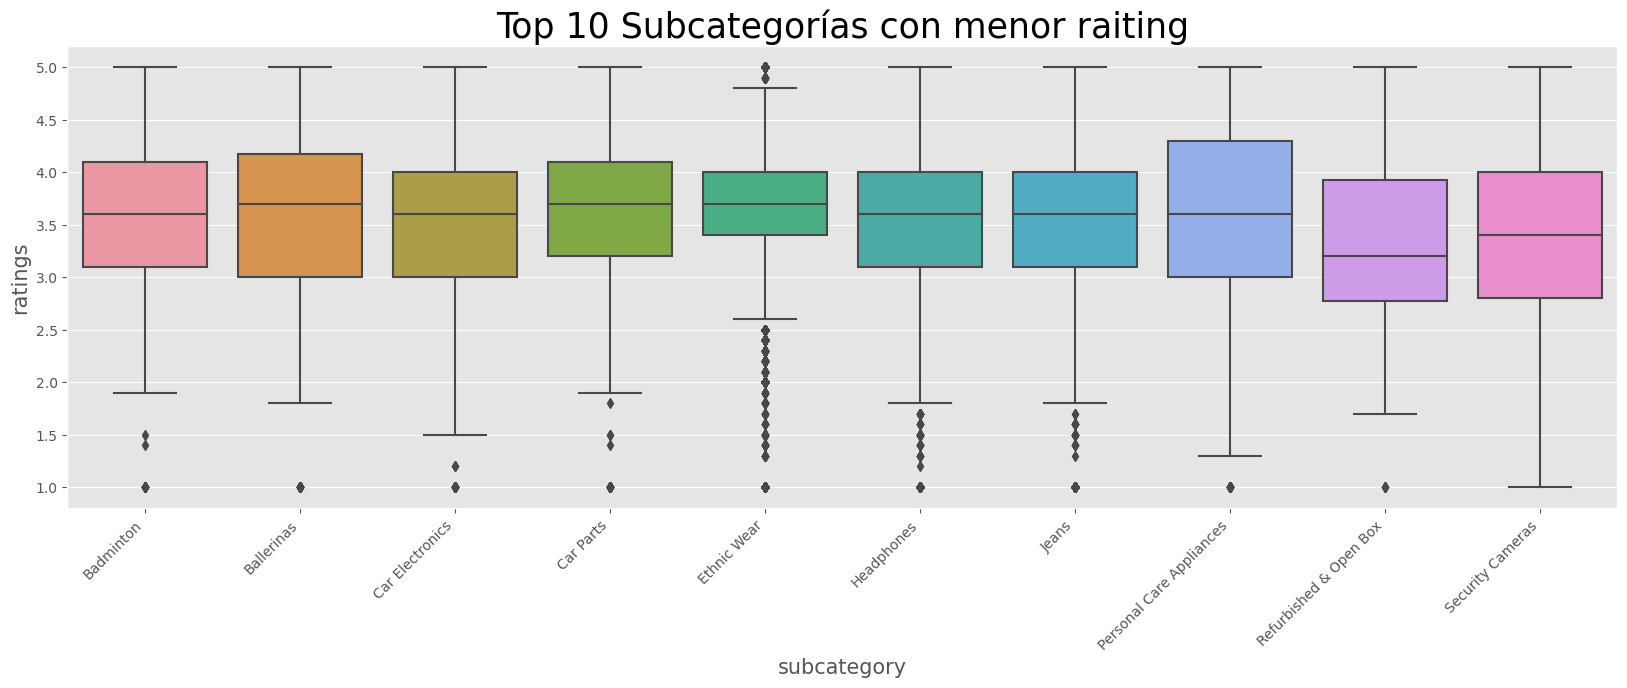

In [224]:
# Buscamos las 10 subcategorias con menor rating tomando como criterio el
# de mayor mediana en los datos
subcategories_order_by_ratings = df_cleaned.groupby('sub_category')['ratings'].describe().sort_values(by = '50%', ascending = True)
top_10_subcategories_by_ratings = subcategories_order_by_ratings.index[:10]
df_cleaned_subcategory_ratings= df_cleaned.loc[df_cleaned['sub_category'].isin(top_10_subcategories_by_ratings)]

# Graficamos el rango de precios de las 10 subcategorías con menor raiting
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=df_cleaned_subcategory_ratings, x="sub_category", y="ratings")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('ratings', fontsize = 15)
ax.set_xlabel('subcategory', fontsize = 15)
ax.set_title('Top 10 Subcategorías con menor raiting', fontsize = 25) 
plt.show()

Observaciones:
- Los productos mejor calificados son 'pet supplies', 'beauty & health' y 'music'. Mientras que la que recibio en general las calificaciones más bajas son las de 'home, kitchen, pets'.
- Las subcategorías mejor calificadas son los juguetes (International Toy Store y STEM Toys Store), televisiones, mochilas y productos de para bebé (Strollers & Prams, Baby Bath, Skin & Grooming). Mientras que las que tienen las calificaciones mas bajas son 'Refurbidesh and Open Box' 

<AxesSubplot:>

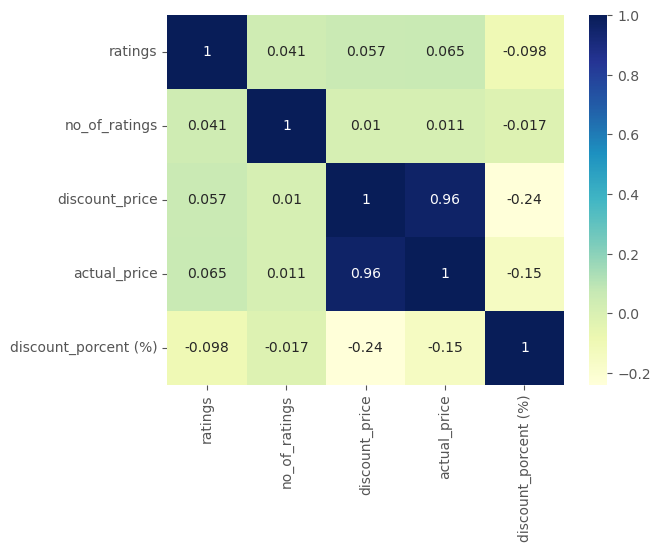

In [225]:
# Visualizamos si existe alguna correlación lineal entre las variables numéricas
sns.heatmap(df_cleaned.corr(), annot = True, cmap = 'YlGnBu')

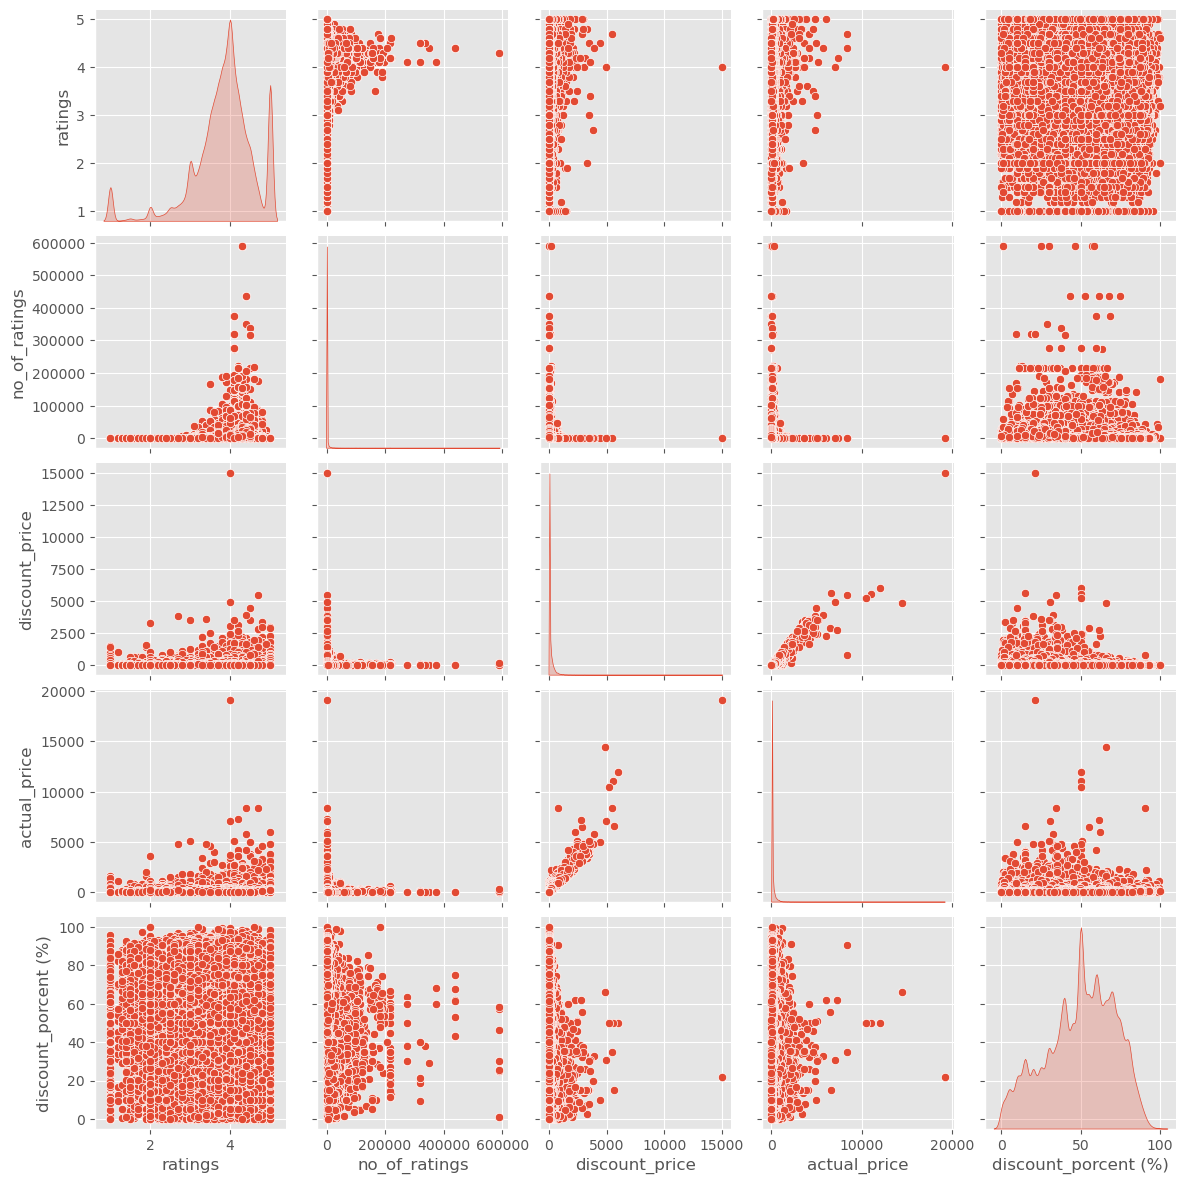

In [226]:
# Realizamos graficas de dispersión entre todas las variables numericas
g = sns.pairplot(df_cleaned, diag_kind = 'kde')
g.fig.set_size_inches(12,12)
plt.show()

In [227]:
# Realizamos una regresion linal entre actual_price vs discount_price
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Generamos un dataframe con las columnas de interes y neliminamos los valores nulos
df_prices = df_cleaned[['actual_price', 'discount_price']]
df_prices.dropna(inplace = True)

# Creamos, entrenamos y evaluamos el modelo
model = LinearRegression()
model.fit(df_prices[['actual_price']], df_prices[['discount_price']])
df_prices['predict'] = model.predict(df_prices[['actual_price']])
r2 = r2_score(df_prices['discount_price'], df_prices['predict'])

Coeficiente de determinación (R2): 0.9159637822179457


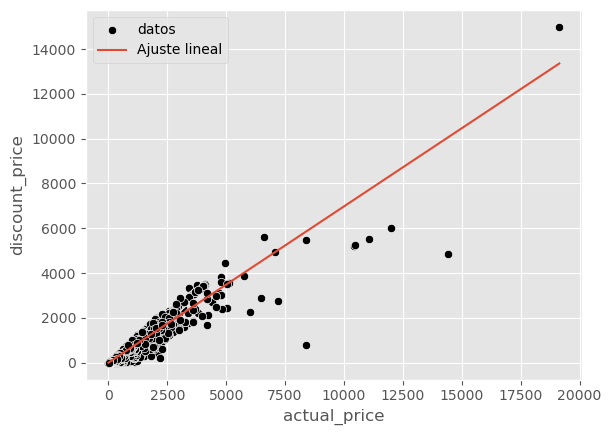

In [228]:
# Graficamos el ajuste lineal
sns.scatterplot(data = df_prices, x = 'actual_price', y = 'discount_price', color = 'black', label = 'datos')
X = np.linspace(min(df_prices['actual_price']), max(df_prices['actual_price']), 100)
y = model.predict(X.reshape(len(X),1))
sns.lineplot(x = X, y = y.reshape(len(y)), label = 'Ajuste lineal')
print(f'Coeficiente de determinación (R2): {r2}')
plt.legend()
plt.show()



Observaciones:
- De la matriz de correlación, podemos ver una fuerte correlación positiva entre el precio actual y el precio en descuento. Al realizar la regresión lineal vemos que se obtiene un buen ajuste con un coef. de determinación $R^2 = 0.91$
- Hay algunas tendencias que se visualizan en la gráfica de dispersión, por ejemplo en ratings vs no_of_ratings hay una tedencia a la alza, pero esto es debido a que la mayoría de las calificaciones rondan entre 3.5 y 5. De ahi en fuera no hay alguna otra relación aparente.

## 4. Conclusiones

Sobre los productos:
- Contamos con un listado de 533713 de productos divididos en 20 Categorías, donde los más comprados son Accesorios (20%), seguido de la Ropa para mujer (17 %) y TV, audio y cámaras (12%).
- Contamos con 112 Subcategorías, de las cuales la Ropa Etnica y Joyería son las más vendidas (6% y 4% respectivamente).
- Las compañias con mayor cantidad de productos son Puma (0.89%), Shopnet (0.79%) y orignales de Amazon (0.70%).

Sobre la opinión de la gente:
- En general, los productos tienen buen recibimiento pues el 75% tienen calificaciones mayores a 3.5, donde las calificacioes más comunes son 4.0, 4.1 y 4.9.
- Los productos con mayor raiting son los juguetes (International Toy Store y STEM Toys Store), televisiones, mochilas y productos de para bebé (Strollers & Prams, Baby Bath, Skin & Grooming) Los que tienen menor calificación son los productos reacondicionados 'Refurbished & Open Box'.

Sobre los precios y descuentos
- Los precios son variados pero el 90% de los productos no pasan de los $90 dolares. La categoría con los productos más caros es TV, audio y Cámaras y la subcategoría es Televisiones. El producto más caro pertenece a estos grupos y es una TV Samsung de 85 pulgadas con un costo de $19138.
- Los precios en descuentos son muy favorables, la mayoría ronda entre el 40% y el 60%. Incluso el 1% de los productos recibe descuentos de 87% o más.
- Los productos con mayores descuentos son aquellos que pertenecen a subcategorías de ropa para mujeres y Accesorios como 'Fashion & Silver Jewellery', 'Ethnic Wear' y 'Women's Fashion'. Mientras que las que reciben menos descuentos son aquellas que tienen que ver con alimentación, salud y belleza como 'Coffee, Tea & Beverages', 'All Grocery & Gourmet Foods', 'Snack Foods','Diet & Nutrition' 'Health & Personal Care' y 'Beauty & Grooming'.

Relaciones entre columnas:
- Existe una fuerte correlación lineal ($\rho$ = 0.96) entre el precio y el precio de descuento. A mayor precio, mayor descuento recibe.
- No encontramos relación entre el precio o el descuento con la calificación de los productos.